investigate the topic specialization of domestic funding and cofunding across countries

In [364]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gp
from ast import literal_eval
import networkx as nx
from adjustText import adjust_text
import matplotlib

In [49]:
pubs_path="../../data/nf_folder/Data/DerivedData/CleanedRawData/pubs_author_funder.csv"
convert_path="../../data/nf_folder/Data/AdditionalData/cntry_convert.xlsx"

In [3]:
pubs_author_funder = pd.read_csv(pubs_path)
pubs_author_funder['author_country'] = pubs_author_funder['author_country'].apply(literal_eval)
pubs_author_funder['funder_country'] = pubs_author_funder['funder_country'].apply(
    lambda x:literal_eval(x) if pd.notnull(x) else "Not-Funded")

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
def assign_type(x):
    label='Not-Funded'
    if x!='Not-Funded' and len(set(x))>1:
        label='1'
    elif x!='Not-Funded':
        label='0'
    return label
pubs_author_funder['cofund']=pubs_author_funder['funder_country'].apply(
    lambda x:assign_type(x))

In [5]:
paf=pubs_author_funder.copy()

In [6]:
paf

,id,author_country,funder_country,discipline,year,rel_citation,citation,cofund
0,30507292,[Turkey],[Turkey],77,2009,0.485,6,0
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9,0
2,30574691,[Russia],[Russia],83,2009,0.312,4,0
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1,0
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3,0
...,...,...,...,...,...,...,...,...
12759123,65301180,[Pakistan],Not-Funded,89,2018,0.000,0,Not-Funded
12759124,65301286,"[Singapore, Singapore]",Not-Funded,44,2017,0.264,1,Not-Funded
12759125,65301288,[Iran],Not-Funded,96,2017,0.000,0,Not-Funded
12759126,65301295,[Israel],Not-Funded,96,2017,0.000,0,Not-Funded


In [7]:
disfund=paf.groupby(['discipline','cofund']).size().reset_index(name='count')
disfund=disfund.pivot_table(index='discipline',columns='cofund',values='count',fill_value=0)

In [8]:
disfund.columns=['sfund','cofund','not']

In [9]:
disfund['total']=disfund['sfund']+disfund['cofund']+disfund['not']

In [10]:
disfund['sfund_r']=disfund['sfund']/disfund['total']
disfund['cofund_r']=disfund['cofund']/disfund['total']

In [11]:
disfund.sort_values(by='cofund_r').head(2)

,sfund,cofund,not,total,sfund_r,cofund_r
discipline,,,,,,
63,39158,3439,174859,217456,0.180073,0.015815
55,12090,1136,38927,52153,0.231818,0.021782


In [12]:
paf['authorlist']=paf['author_country'].apply(lambda x:list(set(x)))

In [15]:
paf['funderlist']=paf['funder_country'].apply(lambda x:list(set(x)) if x!='Not-Funded' else 'Not-Funded')

In [166]:
disname=pd.read_csv("../../data/nf_folder/Data/RawData/discipline_code.csv")
disname.columns=['discipline','disname']
disdict=dict(zip(disname.discipline.values,disname.disname.values))

In [168]:
paf=paf.replace(to_replace={"discipline":disdict})

In [170]:
paf.head(2)

,id,author_country,funder_country,discipline,year,rel_citation,citation,cofund,authorlist,funderlist
0,30507292,[Turkey],[Turkey],Computers,2009,0.485,6,0,[Turkey],[Turkey]
1,30574690,"[United States, France]","[United States, United States, United States, ...",Mechanical Engineering,2009,0.703,9,0,"[France, United States]",[United States]


In [171]:
cntrypub=paf[['id','discipline','year','cofund','authorlist','funderlist']].explode('authorlist')

In [50]:
convert_df = pd.read_excel(convert_path)
euset = set(convert_df[convert_df.EU==1].Country.tolist())

<ipython-input-50-bbdd99f44eab>:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  convert_df = pd.read_excel(convert_path)


In [172]:
def assign_type(author, funderlist):
    label=0
    if funderlist=='Not-Funded':
        label='not'
    elif (author in euset) and ('EU' in funderlist):
        label='cofund'
    elif (author in funderlist) and (len(funderlist)==1):
        label='single'
    elif (author in funderlist) and (len(funderlist)>1):
        label='cofund'
    else:
        label='foreign'
    return label
cntrypub['ftype']=cntrypub[['authorlist','funderlist']].apply(
    lambda x:assign_type(x.authorlist, x.funderlist),axis=1)

In [329]:
cpt1=cntrypub[cntrypub.year>=2014]

In [330]:
cpt1=cpt1.groupby(['authorlist','discipline','ftype']).size().reset_index(name='count')

In [331]:
cpt1=cpt1.pivot_table(index=['authorlist','discipline'],columns='ftype',values='count',fill_value=0)

In [332]:
cpt1=cpt1[['single','cofund','foreign','not']]

In [333]:
cpt1=cpt1.div(cpt1.sum(axis=1), axis=0)
cpt1=cpt1.reset_index()

In [334]:
cpt1.head(2)

ftype,authorlist,discipline,single,cofund,foreign,not
0,Afghanistan,Addictive Diseases,0.0,0.0,0.400000,0.600000
1,Afghanistan,Agricult & Food Science,0.0,0.0,0.470588,0.529412


In [181]:
paft1=paf[paf.year>=2014]
def assign_type(funderlist):
    label=0
    if funderlist=='Not-Funded':
        label='not'
    elif len(funderlist)>1:
        label='cofund'
    elif 'EU' in funderlist:
        label='cofund'
    else:
        label='single'
    return label
paft1['ftype']=paft1['funderlist'].apply(lambda x:assign_type(x))

<ipython-input-181-515877cac613>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paft1['ftype']=paft1['funderlist'].apply(lambda x:assign_type(x))


In [267]:
distype=paft1.groupby(['discipline','ftype']).size().reset_index(name='count')
distype=distype.pivot_table(index='discipline',columns='ftype',values='count',fill_value=0)
distype=distype.div(distype.sum(axis=1), axis=0)

In [268]:
distype=distype.rename(columns={'cofund':'cofund_all','single':'single_all'})

In [269]:
distype=distype.reset_index()

In [270]:
distype['fund']=distype['cofund_all']+distype['single_all']
distype.head()

ftype,discipline,cofund_all,not,single_all,fund
0,Acoustics,0.107970,0.359345,0.532685,0.640655
1,Addictive Diseases,0.070530,0.396603,0.532867,0.603397
2,Aerospace Technology,0.052512,0.471442,0.476046,0.528558
3,Agricult & Food Science,0.067119,0.421192,0.511689,0.578808
4,Allergy,0.160234,0.422586,0.417180,0.577414


In [335]:
distype.head(2)

ftype,discipline,cofund_all,not,single_all,fund
0,Acoustics,0.10797,0.359345,0.532685,0.640655
1,Addictive Diseases,0.07053,0.396603,0.532867,0.603397


In [336]:
cpt1=cpt1.merge(distype[['discipline','single_all','fund']],on='discipline')

In [337]:
cpt1.head(2)

ftype,authorlist,discipline,single,cofund,foreign,not,single_all,fund
0,Afghanistan,Addictive Diseases,0.0,0.0,0.40,0.60,0.532867,0.603397
1,Albania,Addictive Diseases,0.0,0.0,0.25,0.75,0.532867,0.603397


In [338]:
cpt1['single_ratio']=cpt1['single']/cpt1['single_all']
cpt1['fund_ratio']=(cpt1['single']+cpt1['cofund'])/cpt1['fund']

In [355]:
cpt1[cpt1.authorlist=='China'].head(2)

ftype,authorlist,discipline,single,cofund,foreign,not,single_all,fund,single_ratio,fund_ratio
22,China,Addictive Diseases,0.481865,0.098446,0.152850,0.266839,0.532867,0.603397,0.904289,0.961740
160,China,Agricult & Food Science,0.761150,0.046306,0.033435,0.159109,0.511689,0.578808,1.487524,1.395032


In [296]:
graph=nx.read_graphml("graph_full.graphml")

In [307]:
pos={}
for node in graph.nodes():
    x=graph.nodes[node]['x']
    y=graph.nodes[node]['y']
    coords=[x,y]
    pos[node]=coords

In [357]:
nodes=pd.DataFrame(graph.nodes(),columns=['discipline'])

In [493]:
cntrycolor = cpt1[cpt1.authorlist=='Chi'][['discipline','single_ratio','fund_ratio']]
nodecolor=nodes.merge(cntrycolor,on='discipline',how='left')
nodecolor=nodecolor.fillna(0)

In [494]:
def assign_color(s,c):
    color='nan'
    if s>1 and c>1:
        color='both'
    elif s>1 and c<1:
        color='s'
    elif s<1 and c>1:
        color='c'
    elif s!=0 and c!=0:
        color='no'
    return color
nodecolor['type']=nodecolor[['single_ratio','fund_ratio']].apply(
    lambda x: assign_color(x.single_ratio,x.fund_ratio),axis=1)

In [495]:
colordict={'nan':'#F0F0EB','both':'#E82A04','s':'#FFCB11','c':'#1EFF00','no':'#959595'}

In [496]:
nodecolor=nodecolor.replace(to_replace={'type':colordict})
nodecolor.head(2)

,discipline,single_ratio,fund_ratio,type
0,"Social Sciences, Biomedical",0.0,0.0,#F0F0EB
1,Anthropology and Archaeology,0.0,0.0,#F0F0EB


In [497]:
nodelist=nodecolor[(nodecolor.single_ratio>1) | (nodecolor.fund_ratio>1)].discipline

In [498]:
nodecolor = nodecolor.set_index('discipline')
nodecolor = nodecolor.reindex(graph.nodes())

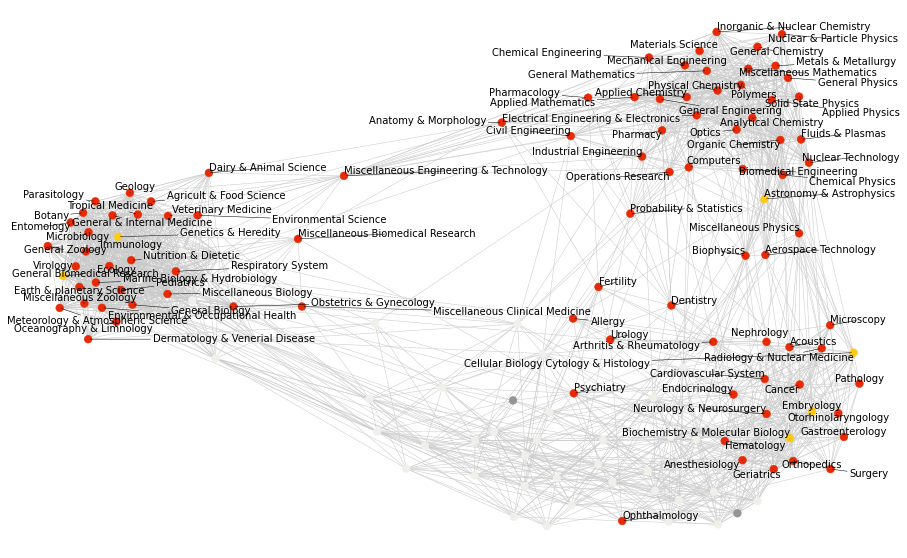

In [499]:
fig, ax=plt.subplots(figsize=(16,10))
text=[]
for node in nodelist:
    x=graph.nodes[node]['x']
    y=graph.nodes[node]['y']
    text.append(plt.text(x,y,node))
nx.draw_networkx(graph,
                 pos=pos,node_size=60,alpha=1,linewidths=0.5,width=0.5,
                 ax=ax,node_color=nodecolor.type.tolist(),
                with_labels=False,edge_color='#C9C9C9')
adjust_text(text, force_points=0.2, force_text=0.2,
            expand_points=(1, 1), expand_text=(1, 1),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
ax.axis('off')
plt.savefig("china.pdf",bbox_inches='tight')

In [457]:
test=cpt1[['authorlist','discipline','single_ratio','fund_ratio']]

<ipython-input-457-1ef0ff695e27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[test.single_ratio>1]['single_ratio']=1


In [464]:
test.loc[test.single_ratio>=1,'single_ratio']=1
test.loc[test.single_ratio<1,'single_ratio']=0

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [468]:
test.groupby(['authorlist'])['single_ratio'].sum().sort_values(ascending=False).head(30)

authorlist
China                 96.0
South Korea           70.0
Taiwan                45.0
Republic of Serbia    35.0
Brazil                30.0
Thailand              17.0
Iran                  15.0
United States         14.0
Czech Republic        11.0
Russia                10.0
Finland               10.0
Malaysia               9.0
Japan                  9.0
Estonia                8.0
Argentina              8.0
Kuwait                 7.0
Sweden                 7.0
Mexico                 6.0
Monaco                 5.0
Saudi Arabia           4.0
Iceland                4.0
Syria                  4.0
Armenia                4.0
Ethiopia               3.0
Sri Lanka              3.0
Georgia                3.0
Chile                  3.0
Brunei                 3.0
Bulgaria               2.0
Gabon                  2.0
Name: single_ratio, dtype: float64